# Platforma ray

In [37]:
import ray
import time
ray.init(dashboard_host='0.0.0.0')

2025-05-22 13:30:59,920	WARNING services.py:2159 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 4294967296 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=6.84gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-05-22 13:31:00,967	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at 172.17.0.2:8265 


Python version:,3.10.12
Ray version:,2.46.0
Dashboard:,http://172.17.0.2:8265


(Concatenator pid=2199) [append called] with param: Stoi na stacji lokomotywa
(Concatenator pid=2199) [append called] with param: Ciężka, ogromna i pot z niej spływa -
(Concatenator pid=2199) [append called] with param: Tłusta oliwa.
(Concatenator pid=2199) [get called]


In [38]:
# ray.shutdown()

Tablica *Dashboard* jest dostępna pod adresem http://localhost:8265

## 1. Zadania (Tasks)
Cytując: *"Ray enables arbitrary functions to be executed asynchronously on separate Python workers. Such functions are called Ray remote functions and their asynchronous invocations are called Ray tasks."*

In [39]:
@ray.remote
def suma(a,b):
    return a + b

In [40]:
# Ta funkcja nie zostanie wywołana
suma(1,2)

TypeError: Remote functions cannot be called directly. Instead of running '__main__.suma()', try '__main__.suma.remote()'.

In [ ]:
# Sprawdż dashboard
suma.remote(1,2)

ObjectRef(c8ef45ccd0112571ffffffffffffffffffffffff0100000001000000)

In [5]:
result_ref = suma.remote(1,2)
# Pobierz wynik
ray.get(result_ref)

3

### 1.1 Składanie wywołań 

In [ ]:
result_ref = suma.remote(suma.remote(1,2),suma.remote(3,4))
ray.get(result_ref)

10

Zadania ```suma.remote(1,2)``` i ```suma.remote(3,4)``` mogą być wykonywane współbieżnie na różnych węzłach obliczeniowych. Zadanie zwracające ostateczny wynik będzie oczekiwało na zakończenie poprzednich.

Ray analizuje zależności między funkcjami i tworzy graf zależności, który jest używany do efektywnego i równoległego wykonania zadań. 

In [7]:
r1 = suma.remote(1,2)
r2 = suma.remote(3,4)
result_ref = suma.remote(r1,r2)
ray.get(result_ref)

10

### 1.2 Jeśli funkcja nie zwraca wartości

In [8]:
@ray.remote
def void_foo(*params):
    for k in params:
        print(k,end=' ')
    print()

void_foo.remote(1,'ala',3.5,True)

ObjectRef(8849b62d89cb30f9ffffffffffffffffffffffff0100000001000000)

**TODO 1.2.1** Znajdź wydruk Dashboard:Jobs > void_foo > stdout

### 1.3 Ciąg Fibonacciego -  rekurencja
Napisz funkcję obliczającą rekurencyjnie n-tą wartość ciągu Fibbonaciego.
Sprawdź na tablicy Dashboard ile razy była wywołana funckja dla róznych wartości parametrów (ale raczej n <= 10)

In [ ]:
@ray.remote
def fibo(n):
    print(n)
    if n <= 1:
        return n
    else:
        return ray.get(fibo.remote(n-1)) + ray.get(fibo.remote(n-2))

obj_ref = fibo.remote(10)
ray.get(obj_ref)

55

### 1.4 Ciąg Fibonacciego -  iteracyjnie

In [ ]:
@ray.remote
def next_fibo_number(a,b):
    return a + b

obj_ref = next_fibo_number.remote(1,2)
ray.get(obj_ref)


3

**TODO 1.4.1** Wykorzystaj funcję ```next_fibo_number``` do wzynaczenia elementu ciągu Fibboncciego o mnumerze 102 

In [ ]:
@ray.remote
def fibo_iterative(n):
    if n <= 2:
        return 1
        
    a = 1
    b = 1
    
    for _ in range(n-2):
        obj_ref = next_fibo_number.remote(a, b)
        next_num = ray.get(obj_ref)
        a = b
        b = next_num
    
    return b

result = ray.get(fibo_iterative.remote(102))
result



927372692193078999176

Dlaczego w tej wersji działa znacznie szybciej? Jak (zapewne) wyglądają drzewa zależnoci w tych dwóch przypadkach?



### 1.5 Obliczanie pi

**TODO 1.5.1** Napisz funkcję zgodnie ze specyfikacją

In [ ]:
import random
num_slices=100
slice_size=1000_000

@ray.remote
def compute_pi_on_slice(slice_size):
    """
    Params: slice_size - liczba powtórzeń
    Funkcja losuje dwie liczby x i y i sparwdza, czy mieszczą się w ćwiartce koła. Jesli tak, inkremetuje sumę.
    Returns: 4 * suma/ slice_size
    """
    sum_val = 0
    for _ in range(slice_size):
        x = random.random()
        y = random.random()
        if x*x + y*y <= 1.0:
            sum_val += 1
    return 4 * sum_val / slice_size

object_ref = compute_pi_on_slice.remote(slice_size=slice_size)
ray.get(object_ref)

3.140552

In [30]:
# Dashboard
tab_ref = [compute_pi_on_slice.remote(slice_size=slice_size) for i in range(num_slices)]

In [35]:
# Pobiera wszystkie elementy
ray.get(tab_ref)

KeyboardInterrupt: 

In [32]:
tab_ref = [compute_pi_on_slice.remote(slice_size=slice_size) for i in range(num_slices)]

Funkcja ```ray.wait()``` pobiera informacje o gotowych i oczekujących zadaniach na liście

In [ ]:
ready,remaining = ray.wait(tab_ref,num_returns=len(tab_ref),timeout=1)
print('-------------------------- ready ------------------------')
print(ready)
print('------------------------ remaining ----------------------')
print(remaining)

-------------------------- ready ------------------------
[]
------------------------ remaining ----------------------
[ObjectRef(cfb67de10376602effffffffffffffffffffffff0100000001000000), ObjectRef(637b86ce4ad61ff1ffffffffffffffffffffffff0100000001000000), ObjectRef(809d4c65c7eedcb5ffffffffffffffffffffffff0100000001000000), ObjectRef(454ccea03aebe217ffffffffffffffffffffffff0100000001000000), ObjectRef(8ab4f3e3227bc581ffffffffffffffffffffffff0100000001000000), ObjectRef(fef65ba1e7b2dd37ffffffffffffffffffffffff0100000001000000), ObjectRef(55f9c5cb04fa5610ffffffffffffffffffffffff0100000001000000), ObjectRef(1934b31c4c283249ffffffffffffffffffffffff0100000001000000), ObjectRef(ec7a49b33eb0d641ffffffffffffffffffffffff0100000001000000), ObjectRef(0509b58b1c671133ffffffffffffffffffffffff0100000001000000), ObjectRef(bc16655de246f52cffffffffffffffffffffffff0100000001000000), ObjectRef(333e5ab84d73764effffffffffffffffffffffff0100000001000000), ObjectRef(a72089785bb4a14affffffffffffffffffffffff01

## 2. Aktorzy

Cytując: *"Actors extend the Ray API from functions (tasks) to classes. An actor is essentially a stateful worker (or a service). When a new actor is instantiated, a new worker is created, and methods of the actor are scheduled on that specific worker and can access and mutate the state of that worker."*

### 2.1 Aktor łączący teksty

In [41]:
@ray.remote
class Concatenator:
    
    def __init__(self,initial_text=''):
        self.text = initial_text
    
    def append(self,text):
        print(f'[append called] with param: {text}')
        self.text += '\n'
        self.text += text

    def get(self):
        print(f'[get called]')
        return self.text

# wywołanie konstruktora
conc_ref = Concatenator.remote('Lokomotywa') 

# wywołanie zdalnych metod obiektu
conc_ref.append.remote('Stoi na stacji lokomotywa')
conc_ref.append.remote('Ciężka, ogromna i pot z niej spływa -')
conc_ref.append.remote('Tłusta oliwa.') 

text_ref = conc_ref.get.remote()
print(ray.get(text_ref))

# opcjonalnie można usunąć
# del conc_ref

Lokomotywa
Stoi na stacji lokomotywa
Ciężka, ogromna i pot z niej spływa -
Tłusta oliwa.


### 2.2 Aktor zliczający słowa

Counter przechowuje informacje o liczbie wystąpień obiektów

In [42]:
from collections import Counter
counter = Counter()
counter.update([1,1,2,1,1,3,2,'a','a','b'])
counter.most_common(3)


[(1, 4), (2, 2), ('a', 2)]

Wykorzystamy go do policznia wystąpień słów w tekscie

In [43]:
url = 'https://wolnelektury.pl/media/book/txt/w-pustyni-i-w-puszczy.txt'
import requests
text = requests.get(url).text
words = text.split()
words[:30]

['Henryk',
 'Sienkiewicz',
 'W',
 'pustyni',
 'i',
 'w',
 'puszczy',
 'ISBN',
 '978-83-288-2842-1',
 'ROZDZIAŁ',
 'I',
 '—',
 'Wiesz,',
 'Nel',
 '—',
 'mówił',
 'Staś',
 'Tarkowski',
 'do',
 'swojej',
 'przyjaciółki,',
 'małej',
 'Angielki',
 '—',
 'wczoraj',
 'przyszli',
 'zabtie',
 '(policjanci)',
 'i',
 'aresztowali']

Poprawimy wydzielanie symboli

In [44]:
from bs4 import BeautifulSoup
import re
import requests

def tokenize(text): 
    text = BeautifulSoup(text, features="html.parser").get_text(' ')
    text = re.sub(r"[#\",!?;-<>/\\*\\&-]", " ", text) #znaki
    text = re.sub('\[[^\]]*\]',' ',text) #
    text = re.sub(r"[:\.\+\=()–©°′″•↑—]", " ", text) #reszta znaków
    text = re.sub(r"\d+\.?\d*", " ", text) #liczby
    words = text.split()
    return words



from collections import Counter
word_freq = Counter()

url = 'https://wolnelektury.pl/media/book/txt/w-pustyni-i-w-puszczy.txt'

text = requests.get(url).text

words = tokenize(text)
word_freq.update(words)
top_words=word_freq.most_common(10)
top_words

[('i', 3831),
 ('się', 2739),
 ('w', 2061),
 ('na', 1867),
 ('nie', 1776),
 ('z', 1705),
 ('że', 1391),
 ('do', 1185),
 ('a', 820),
 ('to', 757)]

In [45]:
word_freq.most_common()[-20:-1]

[('Publikacja', 1),
 ('zrealizowana', 1),
 ('Reprodukcja', 1),
 ('cyfrowa', 1),
 ('Bibliotekę', 1),
 ('Narodową', 1),
 ('egzemplarza', 1),
 ('pochodzącego', 1),
 ('zbiorów', 1),
 ('BN', 1),
 ('Opracowanie', 1),
 ('redakcyjne', 1),
 ('Izabela', 1),
 ('Erdmann', 1),
 ('Tomasz', 1),
 ('Jodełka', 1),
 ('Burzecki', 1),
 ('Sekuła', 1),
 ('Olga', 1)]

Kolejne uaktualnienie

In [46]:
text = requests.get('https://pl.wikipedia.org/wiki/Polska').text

words = tokenize(text)
word_freq.update(words)
top_words=word_freq.most_common(10)
top_words

[('i', 4585),
 ('w', 3209),
 ('się', 2995),
 ('na', 2213),
 ('z', 2039),
 ('nie', 1815),
 ('że', 1406),
 ('do', 1390),
 ('a', 970),
 ('to', 827)]

**TODO 2.2.1** Napisz klasę (aktora) ```WordCountingActor``` z metodami:
* konstruktorem - inicjalizuje atrybut typu ```Counter```
* tokenize() - wykorzystaj gotową funkcję
* add_text(self,text:str) - dzieli tekst na słowa i uaktualnia licznik
* get_top_words(self,n: int) - zwraca n najczęsciej występujących słów

In [47]:
from collections import Counter
from bs4 import BeautifulSoup
import re

@ray.remote
class WordCountingActor:
    def __init__(self):
        self.counter = Counter()
        

    def tokenize(self, text:str): 
       return tokenize(text)

    def add_text(self, text:str):
       words = self.tokenize(text)
       self.counter.update(words)

    def get_top_words(self,n: int):
        return self.counter.most_common(n)

**TODO 2.2.2** Utwórz aktora i dodawaj teksty pobrane ze stron internetowych. Możesz rozszerzyć przykładową listę. Po dodaniu teksty wypisz 10 najczęściej pojawiająych się słów.

In [56]:
urls = ['https://pl.wikipedia.org/wiki/Akademia_G%C3%B3rniczo-Hutnicza_im._Stanis%C5%82awa_Staszica_w_Krakowie',
        'https://pl.wikipedia.org/wiki/Polska',
        'https://pl.wikipedia.org/wiki/Krak%C3%B3w',
        'https://www.agh.edu.pl/']


In [68]:
wca_ref = WordCountingActor.remote()
for url in urls:
    text = requests.get(url).text
    wca_ref.add_text.remote(text)

top_words = wca_ref.get_top_words.remote(10)

In [69]:
ray.get(top_words)

[('w', 2162),
 ('i', 1419),
 ('z', 716),
 ('na', 620),
 ('się', 449),
 ('W', 390),
 ('do', 388),
 ('r', 370),
 ('Polski', 271),
 ('Kraków', 270)]

## 3. Obiekty (object)

Cytując: *"In Ray, tasks and actors create and compute on objects. We refer to these objects as remote objects because they can be stored anywhere in a Ray cluster, and we use object refs to refer to them. Remote objects are cached in Ray’s distributed shared-memory object store, and there is one object store per node in the cluster. In the cluster setting, a remote object can live on one or many nodes, independent of who holds the object ref(s).*

*An object ref is essentially a pointer or a unique ID that can be used to refer to a remote object without seeing its value. If you’re familiar with futures, Ray object refs are conceptually similar."*

Załadujemy obraz i utworzymy reprezentujący go obiekt

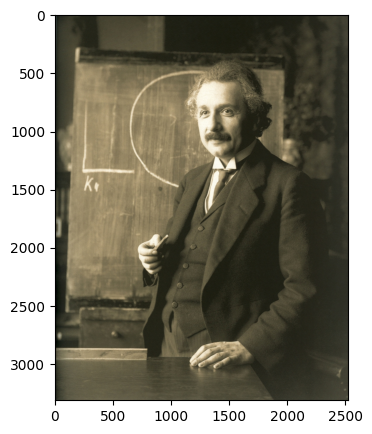

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (5, 5)

response = requests.get('https://upload.wikimedia.org/wikipedia/commons/3/3e/Einstein_1921_by_F_Schmutzer_-_restoration.jpg')
img = Image.open(BytesIO(response.content))
img = np.array(img)

plt.imshow(img,cmap='gray')
plt.show()

In [78]:
img_ref = ray.put(img)

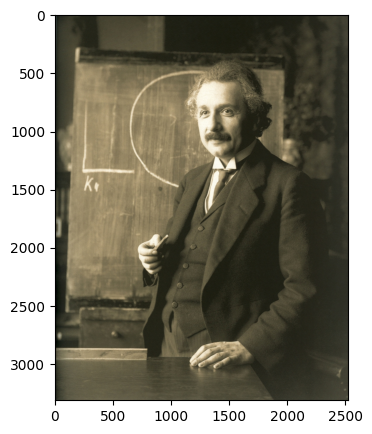

In [79]:
img_copy = ray.get(img_ref)
plt.imshow(img_copy,cmap='gray')
plt.show()

## 4. Biblioteka  Ray Data i Dataset
Cytując: *"Ray Data is a scalable data processing library for ML workloads. It provides flexible and performant APIs for scaling Offline batch inference and Data preprocessing and ingest for ML training. Ray Data uses streaming execution to efficiently process large datasets.*

Podstawową klasą jest ```Dataset```. Podobue, jak w przypadku Sparka możliwy jest:
* odczyt danych z róznych źródeł
* zapis w róznych formatach
* podstawowe transformacje (w tym konwersja do Pandas)
* podział na wsady (batch)
* automatyczne partycjonowanie i rozkładanie pomiędzy węzły
* iteracja po pojedynczych danych lub z podziałem na wsady w formatach zgodnych z Tensorflow i Torch


In [30]:
ds_train = ray.data.read_csv("twitter_training.csv")
ds_test = ray.data.read_csv("twitter_validation.csv")

In [ ]:
ds_train

In [ ]:
ds_train.show(5)

In [ ]:
ds_train.stats()

### 4.1 Podstawowe transformacje

#### to_pandas

In [34]:
df_train = ds_train.to_pandas()
df_test = ds_test.to_pandas()
df_train.head(10)

Read progress 0:   0%|                                                                                        …

Read progress 0:   0%|                                                                                        …

Read progress 0:   0%|                                                                                        …

,TweetId,Entity,Sentiment,TweetContent
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


#### select_columns

In [ ]:
ds2 = ds_train.select_columns(['Entity','Sentiment']).show(5)

#### groupby

In [ ]:
ds2 = ds_train.select_columns(['Entity','Sentiment']).groupby(['Entity','Sentiment']).count()

In [ ]:
ds2.to_pandas()

#### filter

In [38]:
ds2 = ds_train.filter(lambda row:row['Entity']=='Nvidia')

In [ ]:
ds2.show(5)

#### map
Funkcja konwertuje pojedyncze wiersze

In [ ]:
def split_content(row):
    row['words'] = row['TweetContent'].split()
    return row
    
ds_train.map(split_content).show(10)

**TODO 4.1.1** 
* dodaj kolumnę ```word_count``` zawierającą liczbę słów w ```TweetContent```
* zgrupuj po kolumnach ```Entity``` i ```Sentiment```
* za pomocą ```sum(col_name)``` policz ile bylo słów we wpisach należących do danej grupy
* wyświetl jako ```pandas.DataFrame```

In [41]:
def count_words(row):
    
    
# ds_train.map(count_words).show(3)
ds_train.map(count_words)...

2024-04-27 22:12:03,334	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-27_22-04-31_249216_1558/logs/ray-data
2024-04-27 22:12:03,338	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[Map(count_words)] -> LimitOperator[limit=1]


- ReadCSV->SplitBlocks(9) 1:   0%|                                                                            …

- Map(count_words) 2:   0%|                                                                                   …

- limit=1 3:   0%|                                                                                            …

Running 0:   0%|                                                                                              …

2024-04-27 22:12:06,645	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-27_22-04-31_249216_1558/logs/ray-data
2024-04-27 22:12:06,647	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[Map(count_words)] -> AllToAllOperator[Aggregate]


- ReadCSV->SplitBlocks(9) 1:   0%|                                                                            …

- Map(count_words) 2:   0%|                                                                                   …

- Aggregate 3:   0%|                                                                                          …

Shuffle Map 4:   0%|                                                                                          …

Shuffle Reduce 5:   0%|                                                                                       …

Running 0:   0%|                                                                                              …

Sort Sample 0:   0%|                                                                                          …

,Entity,Sentiment,sum(word_count)
0,Amazon,Irrelevant,3737
1,Amazon,Negative,13030
2,Amazon,Neutral,30397
3,Amazon,Positive,5715
4,ApexLegends,Irrelevant,2527


#### flat_map
Funkcja konweruje jeden wiersz na wiele wierszy (analogia do explode)

In [42]:
def explode_content(row):
    words = row['TweetContent'].split()
    return [{'word':w} for w in words]

ds_train.flat_map(explode_content).show(10)

2024-04-27 22:12:28,977	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-27_22-04-31_249216_1558/logs/ray-data
2024-04-27 22:12:28,979	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[FlatMap(explode_content)] -> LimitOperator[limit=10]


- ReadCSV->SplitBlocks(9) 1:   0%|                                                                            …

- FlatMap(explode_content) 2:   0%|                                                                           …

- limit=10 3:   0%|                                                                                           …

Running 0:   0%|                                                                                              …

{'word': 'im'}
{'word': 'getting'}
{'word': 'on'}
{'word': 'borderlands'}
{'word': 'and'}
{'word': 'i'}
{'word': 'will'}
{'word': 'murder'}
{'word': 'you'}
{'word': 'all'}


**TODO 4.1.2** Przepisz funckję ```explode_content()```

W pętli po słowach:
* utwórz kopię ```row```
* dodaj słowo (w kolumnie ```word```)
* dodaj zmodyfikowaną kopię do listy

Zwróć listę

In [43]:
def explode_content(row):
    
    rows = []
    
    return rows

ds_train.flat_map(explode_content).show(10)

2024-04-27 22:12:41,312	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-04-27_22-04-31_249216_1558/logs/ray-data
2024-04-27 22:12:41,316	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[FlatMap(explode_content)] -> LimitOperator[limit=10]


- ReadCSV->SplitBlocks(9) 1:   0%|                                                                            …

- FlatMap(explode_content) 2:   0%|                                                                           …

- limit=10 3:   0%|                                                                                           …

Running 0:   0%|                                                                                              …

{'TweetId': 2401, 'Entity': 'Borderlands', 'Sentiment': 'Positive', 'TweetContent': 'im getting on borderlands and i will murder you all ,', 'word': 'im'}
{'TweetId': 2401, 'Entity': 'Borderlands', 'Sentiment': 'Positive', 'TweetContent': 'im getting on borderlands and i will murder you all ,', 'word': 'getting'}
{'TweetId': 2401, 'Entity': 'Borderlands', 'Sentiment': 'Positive', 'TweetContent': 'im getting on borderlands and i will murder you all ,', 'word': 'on'}
{'TweetId': 2401, 'Entity': 'Borderlands', 'Sentiment': 'Positive', 'TweetContent': 'im getting on borderlands and i will murder you all ,', 'word': 'borderlands'}
{'TweetId': 2401, 'Entity': 'Borderlands', 'Sentiment': 'Positive', 'TweetContent': 'im getting on borderlands and i will murder you all ,', 'word': 'and'}
{'TweetId': 2401, 'Entity': 'Borderlands', 'Sentiment': 'Positive', 'TweetContent': 'im getting on borderlands and i will murder you all ,', 'word': 'i'}
{'TweetId': 2401, 'Entity': 'Borderlands', 'Sentiment': 

#### random_shuffle

In [ ]:
ds_train.random_shuffle(seed=1).to_pandas()

#### iteratory (w tym dzielące na wsady: batch)

In [ ]:
for i,row in enumerate(ds_train.iter_rows()):
    if i==3:
        break
    print(row)

In [ ]:
for i,row in enumerate(ds_train.iter_batches(batch_size=2)):
    if i==3:
        break
    print('-------------')    
    print(row)

## 5. Klasyfikacja

### 5.1 Metryki

**TODO 5.1.1** napisz funkcję, która oblicza i zwraca metryki lub raport klasyfikacji

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

@ray.remote
def get_classification_results(y_true,y_pred,labels=None,return_scores=True):
    """
    Funkcja oblicza wetryki klasyfikacji
    Jeżeli return_scores==True funkcja zwraca słownik zawierający wartości accuracy, precision, recall (w wersji macro)
    Jeżeli return_scores==False funcka zwraca tekst będący wynikiem wywołania classification_report (z etykietami klas)
    """
    

In [49]:
results_ref = get_classification_results.remote([1,1,2,2,3,3],[1,1,2,1,3,3],labels=['a','b','c'])
ray.get(results_ref)

{'accuracy': 0.8333333333333334,
 'precision': 0.8888888888888888,
 'recall': 0.8333333333333334,
 'f1': 0.8222222222222223}

In [50]:
results_ref = get_classification_results.remote([1,1,2,2,3,3],[1,1,2,1,3,3],labels=['a','b','c'],return_scores=False)
print(ray.get(results_ref))

              precision    recall  f1-score   support

           a       0.67      1.00      0.80         2
           b       1.00      0.50      0.67         2
           c       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



### 5.2 train_and_test

**TODO 5.2.1** Napisz funckję zgodnie ze specyfikacją

In [52]:
from sklearn import preprocessing

@ray.remote
def train_and_test(df_train,df_test, model, features_column, target_column,return_scores=True):
    """
    Funkcja (1) stosuje preprocessing.LabelEncoder() dla zbudowania wektorów liczbowych etykiet y_train oraz y_test
    (2) przeprowadza uczenie modelu
    (3) wyznacza wartości przewidywanych etykiet dla zbioru treningowego i testowego
    (4) wyznacza metryki predykcji dla zbioru uczącego i testowego wywołując get_classification_results
    
    Params: df_train - zbiór treningowy
            df_test  - zbiór testowy
            model - model klasyfikatora (algorytm) 
            features_column - kolumna zawierająca cechy
            target_column - kolumna z etykietami
            return_scores - analogicznie, jak get_classification_results
    Returns:
            Słownik zawierający następujące elementy
            * 'train' - metryki dla zbioru treningowego
            * 'test' - metryki dla zbioru uczącego
            * 'model' - wytrenowany model
            * 'labels' - etykiety
    """
    
    


### 5.3 Wywołanie

In [ ]:
ds_train = ray.data.read_csv("twitter_training.csv")
ds_test = ray.data.read_csv("twitter_validation.csv")
df_train = ds_train.to_pandas()
df_test = ds_test.to_pandas()
df_train_ref = ray.put(df_train)
df_test_ref = ray.put(df_test)

**TODO 5.3.1** Wywołaj funkcję przekazując referencje do odpowiednich obiektów Ray

In [54]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([('vect', CountVectorizer()), ('cls', MultinomialNB())])
results_ref = train_and_test.remote(...)

In [55]:
results = ray.get(results_ref)

In [56]:
ray.get(results['train'])

{'accuracy': 0.7963766369406282,
 'precision': 0.819132108265895,
 'recall': 0.7831437089896423,
 'f1': 0.7935849161197497}

In [57]:
ray.get(results['test'])

{'accuracy': 0.825,
 'precision': 0.8389426103407482,
 'recall': 0.8178315799363239,
 'f1': 0.8230766650524841}

**TODO 5.3.2** Wywołaj funkcję dla innego klasyfikatora i odczytaj wyniki

In [58]:
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
pipeline = Pipeline([('vect', CountVectorizer()), ('cls', SGDClassifier(loss='perceptron', penalty='l2', alpha=1e-3))])


In [59]:
results = 

In [60]:
#train


{'accuracy': 0.8755925122519482,
 'precision': 0.8795214429804623,
 'recall': 0.8717285798167163,
 'f1': 0.8747129005829772}

In [61]:
# test

{'accuracy': 0.927,
 'precision': 0.9275372973059509,
 'recall': 0.9260236372982662,
 'f1': 0.9266962508727952}

## 6. Walidacja krzyżowa

**TODO 6.1.1** Napisz funkcję zgodnie ze specyfikacją. 

Będzie realizowała pojedyncze zadanie wywoływane podczas walidacji krzyżowej (uczenie na k-1 podzbiorach, testowanie na jednym pozostawionym podzbiorze). 
* Te zadania można zrównoleglić.
* Zbiór, na którym będzie wykonywana walidacja krzyżowa będzie obiektem
* Zadania będą wywoływane z róznymi zestawami indeksów odpowiadającymi podziałowi na podzbiory (*ang. fold*) uzyte do budowy modelu i testowania

In [62]:
@ray.remote
def train_and_test_fold(df,train_indexes,test_indexes, model,features_column, target_column,return_scores=True):
    """
    Funkcja
    (1) dzieli zbiór na podzbiór dt_train treningowy i df_test testowy na podstawie indeksów wierszy 
    (2) stosuje preprocessing.LabelEncoder() dla zbudowania wektorów liczbowych etykiet y_train oraz y_test
    (3) przeprowadza uczenie modelu
    (4) wyznacza wartości przewidywanych etykiet dla zbioru treningowego i testowego
    (5) wyznacza metryki predykcji dla zbioru uczącego i testowego wywołując get_classification_results
    
    Params: df - zbiór poddany walidacji krzyżowej 
            train_indexes - indeksy wierszy podzbioru treningowego (z 
            test_indexes  - indeksy wierszy podzbioru testowego
            model - model klasyfikatora (algorytm) 
            features_column - kolumna zawierająca cechy
            target_column - kolumna z etykietami
            return_scores - analogicznie, jak get_classification_results
    Returns:
            Słownik zawierający następujące elementy
            * 'train' - metryki dla zbioru treningowego
            * 'test' - metryki dla zbioru uczącego
            * 'model' - wytrenowany model
            * 'labels' - etykiety
    """
    
    


Przykład funkcji realizującej walidację krzyzową ze stratyfikacją (podziałem zachowującym prawdopodobieństwo a-priori klas)

In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

@ray.remote
def cross_validate_stratified(df,model, features_column, target_column ,n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits)
    result_refs=[]
    for i, (train_indexes, test_indexes) in enumerate(skf.split(df_train, df_train[target_column])):
        result_refs.append(train_and_test_fold.remote(df_train,train_indexes, test_indexes,clone(model),features_column, target_column))
    return result_refs

**TODO 6.1.2** napisz analogiczną funkcję bez startyfikacji, posługująca się klasa ```KFold```

In [64]:
from sklearn.model_selection import KFold
from sklearn.base import clone




In [65]:
pipeline = Pipeline([('vect', CountVectorizer()), ('cls', SGDClassifier(loss='perceptron', penalty='l2', alpha=1e-3))])
results_ref = cross_validate_stratified.remote(df_train_ref, 
                                    pipeline,
                                    features_column='TweetContent', target_column='Sentiment')

**TODO 6.1.3** Odczytaj wyniki

train {'accuracy': 0.8898278606817134, 'precision': 0.8911304883297855, 'recall': 0.8878996366869284, 'f1': 0.8893661435433775}
test {'accuracy': 0.4360690855536216, 'precision': 0.42994047046660894, 'recall': 0.42466689688440096, 'f1': 0.42178545226434544}
train {'accuracy': 0.8911520092839182, 'precision': 0.8924257876098458, 'recall': 0.8912117934523252, 'f1': 0.8912208667927195}
test {'accuracy': 0.4228142991029589, 'precision': 0.426252405163982, 'recall': 0.4103779190427649, 'f1': 0.41028188947474686}
train {'accuracy': 0.8937870086589104, 'precision': 0.8977167796557702, 'recall': 0.89076967062012, 'f1': 0.8935159011064373}
test {'accuracy': 0.3532404927691484, 'precision': 0.33984564821632757, 'recall': 0.3366352761281294, 'f1': 0.33013953693547415}
train {'accuracy': 0.8949772368851727, 'precision': 0.895520122130066, 'recall': 0.8931773460174912, 'f1': 0.894197958714404}
test {'accuracy': 0.3445366898768077, 'precision': 0.33308059797699024, 'recall': 0.33383837420343015, 'f1

**TODO 6.1.4** Wywołaj funkcję ```cross_validate()``` i odczytaj wyniki

In [70]:
pipeline = Pipeline([('vect', CountVectorizer()), ('cls', SGDClassifier(loss='perceptron', penalty='l2', alpha=1e-3))])
results_ref = cross_validate.remote(...)

train {'accuracy': 0.8846949250888965, 'precision': 0.8846290605183472, 'recall': 0.8828872550602964, 'f1': 0.883727923907619}
test {'accuracy': 0.820591779354666, 'precision': 0.8188360732382993, 'recall': 0.8174282900994183, 'f1': 0.8180580391116251}
train {'accuracy': 0.8583756118608007, 'precision': 0.8651693393852057, 'recall': 0.8542518808883283, 'f1': 0.8580901349317475}
test {'accuracy': 0.8017137501673585, 'precision': 0.8079829294537665, 'recall': 0.7984933794779632, 'f1': 0.8010541446732996}
train {'accuracy': 0.8842056714374982, 'precision': 0.8880867467548912, 'recall': 0.8801254121207385, 'f1': 0.8835736347351826}
test {'accuracy': 0.8237814675950723, 'precision': 0.825617786981492, 'recall': 0.8182157297863012, 'f1': 0.8209939372929492}
train {'accuracy': 0.8872109977088106, 'precision': 0.8874969448649753, 'recall': 0.8859597363666855, 'f1': 0.8862495566373111}
test {'accuracy': 0.8319496518478843, 'precision': 0.8322173412011109, 'recall': 0.8304338894393799, 'f1': 0.8

## 7. Modele dla Entity 

Spróbujemy zbudować indywidaualne klasyfikatory dla ocenianych obiektów *Entity*

In [74]:
df_train.Entity.unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

**TODO 7.1.1** W petli po podzbiorach danych:
* utwórz Pipeline
* wywołaj funkcję ```train_and_test()```
* umieść wyniki (classification_report) w słowniku konwerując nazwę obiektu na małe litery
* wyświetl wyniki dla testów

In [75]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

results={}    
for ent in df_train.Entity.unique():
    ...

In [76]:
for k in results:
    print(f'-------------- {k} ------------')
    ...

-------------- borderlands ------------
              precision    recall  f1-score   support

  Irrelevant       1.00      0.97      0.98       240
    Negative       1.00      0.97      0.98       426
     Neutral       0.98      0.97      0.98       600
    Positive       0.97      1.00      0.98      1020

    accuracy                           0.98      2286
   macro avg       0.99      0.98      0.98      2286
weighted avg       0.98      0.98      0.98      2286

-------------- callofdutyblackopscoldwar ------------
              precision    recall  f1-score   support

  Irrelevant       0.91      0.97      0.94       576
    Negative       0.98      0.95      0.97       576
     Neutral       0.99      0.93      0.96       360
    Positive       0.98      0.98      0.98       864

    accuracy                           0.96      2376
   macro avg       0.96      0.96      0.96      2376
weighted avg       0.96      0.96      0.96      2376

-------------- amazon ------------
 

**TODO 7.1.2** Doaj jeszcze do słownika wyniki dla pełnego zbioru (pod kluczem ```*```)

In [77]:
pipeline = Pipeline([('vect', CountVectorizer()), ('cls', SGDClassifier(loss='perceptron', penalty='l2', alpha=1e-3))])
results['*'] = train_and_test.remote(df_train,df_test,pipeline,features_column='TweetContent', target_column='Sentiment', return_scores=False)

**TODO 7.1.3** Wyekstrahuj z rezuultatów dwa słowniki: ```models```  z modelami oraz ```labels``` z etykietami.

Etykiety występują zawsze w tej samej kolejności, ale to specyfika zbioru danych. Gdyby zastosować permutację, przed uczeniem, kolejność byłaby inna, więc *better save than sorry...*

In [78]:
models = ???
models

{'borderlands': Pipeline(steps=[('vect', CountVectorizer()),
                 ('cls', SGDClassifier(alpha=0.001, loss='perceptron'))]),
 'callofdutyblackopscoldwar': Pipeline(steps=[('vect', CountVectorizer()),
                 ('cls', SGDClassifier(alpha=0.001, loss='perceptron'))]),
 'amazon': Pipeline(steps=[('vect', CountVectorizer()),
                 ('cls', SGDClassifier(alpha=0.001, loss='perceptron'))]),
 'overwatch': Pipeline(steps=[('vect', CountVectorizer()),
                 ('cls', SGDClassifier(alpha=0.001, loss='perceptron'))]),
 'xbox(xseries)': Pipeline(steps=[('vect', CountVectorizer()),
                 ('cls', SGDClassifier(alpha=0.001, loss='perceptron'))]),
 'nba2k': Pipeline(steps=[('vect', CountVectorizer()),
                 ('cls', SGDClassifier(alpha=0.001, loss='perceptron'))]),
 'dota2': Pipeline(steps=[('vect', CountVectorizer()),
                 ('cls', SGDClassifier(alpha=0.001, loss='perceptron'))]),
 'playstation5(ps5)': Pipeline(steps=[('vect', Coun

In [79]:
labels = ???
labels

{'borderlands': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'callofdutyblackopscoldwar': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'amazon': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'overwatch': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'xbox(xseries)': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'nba2k': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'dota2': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'playstation5(ps5)': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'worldofcraft': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'cs-go': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'google': array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object),
 'assassinscreed': array(['Irrelevant',

Poniższa funkcja dokonuje klasyfikacji tekstu dla danego typu obiektu (entity). Jesli nie zostanie znaleziony, stosuje klucz ```*```

Wypróbuj jej działanie wpisując rózne wartości...

In [80]:
def classify(models,labels,ent,text):
    k = ent.lower()
    if not k in models:
        k = '*'
    y_pred =  models[k].predict([text])
    return labels[k][y_pred[0]]
    
classify(models,labels,'*','low energy card')

'Irrelevant'

In [81]:
classify(models,labels,'nvidia','low energy card')

'Positive'

## 8. Ray serve

Ray Serve to framework do zarządzania mikrousługami, który został stworzony na platformie Ray. Pozwala on na łatwe tworzenie, wdrażanie i skalowanie aplikacji opartych na mikrousługach. 

Cechy:

* **Prostota użycia:** Ray Serve zapewnia proste API do definiowania i wdrażania mikrousług. Programiści mogą definiować obsługę żądań za pomocą zwykłych funkcji Pythona.
* **Elastyczność i skalowalność:** Ray Serve automatycznie zarządza skalowaniem i równoważeniem obciążenia mikrousług, co umożliwia obsługę wysokiego obciążenia aplikacji.
* **Obsługa wielu typów modeli:** Ray Serve obsługuje wiele rodzajów modeli, w tym modele oparte na frameworkach uczenia maszynowego, takich jak TensorFlow, PyTorch czy Scikit-learn.
* **Obsługa wielu typów interfejsów:** Obsługuje różne interfejsy API, takie jak REST, gRPC, HTTP oraz in-memory Python API, co umożliwia łatwe integrowanie z różnymi typami aplikacji.
* **Rozproszenie i równoległość:** Dzięki wykorzystaniu platformy Ray, Ray Serve oferuje wbudowane wsparcie dla równoległego przetwarzania i rozproszenia, co pozwala na obsługę wysokich obciążeń i dużych ilości danych.

In [82]:
from ray import serve
# serve.shutdown()
serve.start(http_options={'host':'0.0.0.0','port':8000})

### 8.1 Przykład wdrożenia mikrousługi

Pokazemy prosty przykład usług REST. Dzięki (opcjonalnej) integracji z FastApi możliwe będzie wywołanie poprzez interfejs *Swagger*

In [ ]:
import requests
from fastapi import FastAPI
from ray import serve
# import uvicorn

# 1: Define a FastAPI app and wrap it in a deployment with a route handler.
app = FastAPI()


@serve.deployment
@serve.ingress(app)
class FastAPIDeployment:
    # FastAPI will automatically parse the HTTP request for us.
    @app.get("/hello")
    def say_hello(self, firstname: str, surname: str) -> str:
        return f"Hello {firstname} {surname}!"


# 2: Deploy the deployment.
# serve.shutdown()
# serve.start(http_options={'host':'0.0.0.0','port':8000})
serve.run(FastAPIDeployment.bind(), route_prefix="/")

# otwórz http://localhost:8000/docs

In [ ]:
print(requests.get("http://0.0.0.0:8000/hello", params={"firstname": "Jan",'surname':'Kowalski'}).text)

Otwórz stronę http://localhost:8000/docs#/default/say_hello_hello_get i wypróbuj serwis

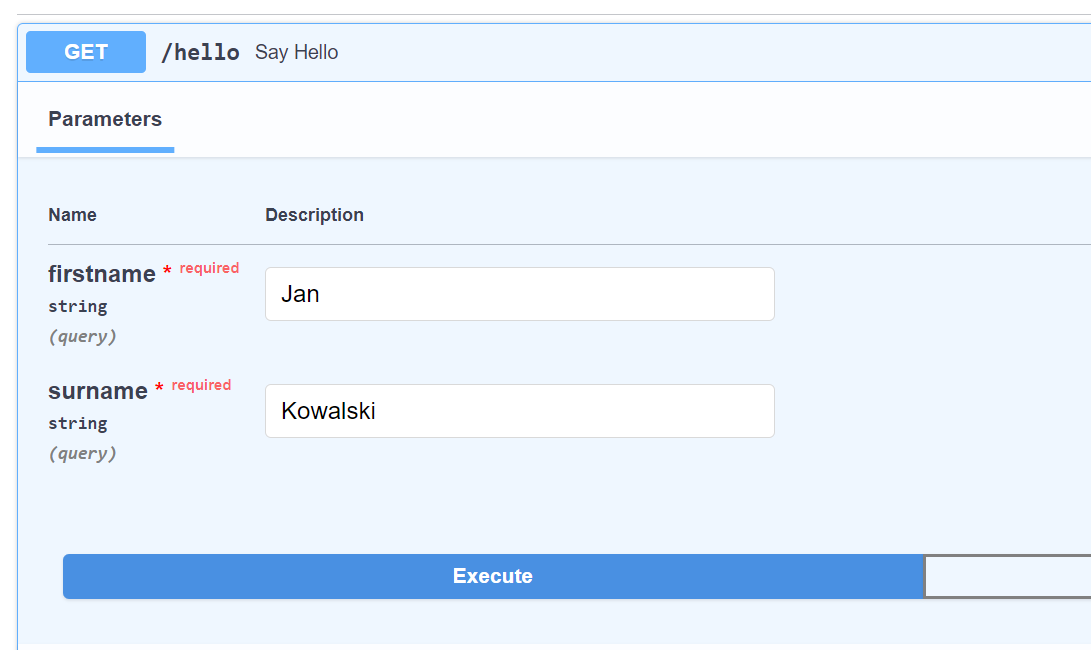

Otwórz stronę http://localhost:8000/docs#/default/say_hello_hello_get i wypróbuj serwis

### 8.2 Wdrożenie zbudowanego zbioru modeli jako mikroserwis

**TODO 8.2.1** zaimplementuj klasę ```ClassifierDeployment```
* W konstruktorze przekaż słowniki z modelami i etykietami
* Zaimplementuj metodę ```calssify`` zgodnie ze specyfikacją

In [ ]:
import requests
from fastapi import FastAPI
from ray import serve
# import uvicorn

# 1: Define a FastAPI app and wrap it in a deployment with a route handler.
app = FastAPI()


@serve.deployment
@serve.ingress(app)
class ClassifierDeployment:
    
    def __init__(self,models,labels):
       
        
    # FastAPI will automatically parse the HTTP request for us.
    @app.get("/classify")
    def classify(self, entity: str, text: str) -> str:
        """
        Params: entity:str nazwa obiektu
                text: treść wypowiedzi do sklasyfikowania
        Returns: 
                tekstową etykietę (Irrevelant, Positive, Neutral, Negative)
        
        """
        


# 2: Deploy the deployment.

app = ClassifierDeployment.bind(????)
serve.run(app, route_prefix="/")

Wyświetlimy przykładowe wypowiedzi

In [ ]:
ds_train.filter(lambda row:row['Entity']=='Nvidia').random_shuffle(seed=1).to_pandas().head(20)

**TODO 8.2.2** Zamieśc kilka przykładowych wywołań mikroserwisu

In [87]:
print(requests.get("http://0.0.0.0:8000/classify", params={"entity": "nvidia",'text':'so like, is there even a single game where'}).json())

Negative


**TODO 8.2.3** Powtórz wywołanie w intefejsie Swaggera. Możesz wkleić bezpośrednio zrzuty ekranu

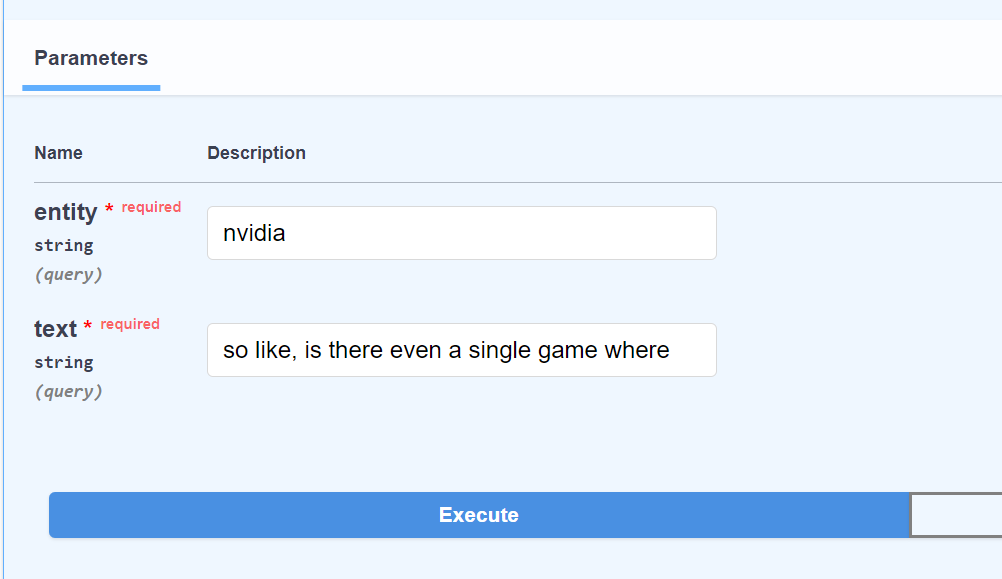

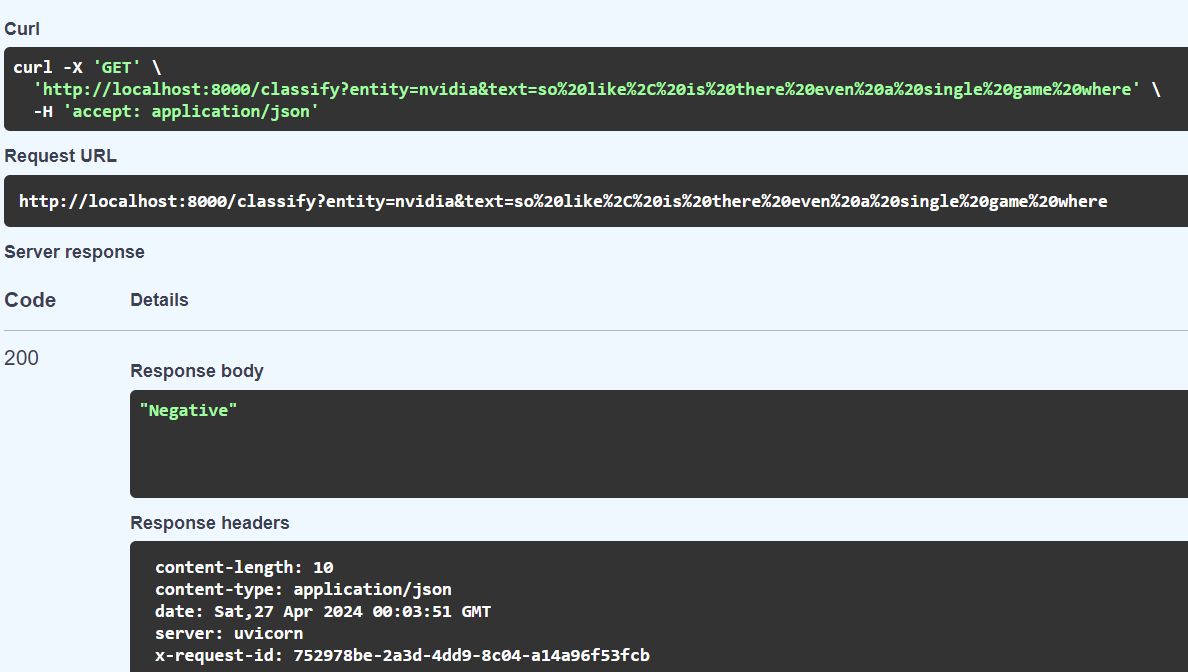
